In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import io
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import logging
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.INFO)

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
from itertools import combinations
# import gaussian kde
from scipy.stats import gaussian_kde
import matplotlib as mpl

In [2]:
plt.rcParams['xtick.labelsize'] = 22 # or whatever size you want
plt.rcParams['ytick.labelsize'] = 22 # or whatever size you want

# Set global font size for labels, titles and legends
plt.rcParams['axes.labelsize'] = 22 # or whatever size you want
plt.rcParams['axes.titlesize'] = 22 # or whatever size you want
plt.rcParams['legend.fontsize'] = 22 # or whatever size you want
#plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True


In [3]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42

mpl.rcParams['svg.fonttype'] = 'none'

#### Figure 7 E Model perturbation

In [4]:
# import files related to the perturbations

foskojundkd = pd.read_csv('processed_simulations/20250313_COLO858_FOS_KO_custom_fos_0.50_junfos_0.00_JUND_KD_steady_states_results_a_4.00_b_13.30_V4.csv')
junkojundkd = pd.read_csv('processed_simulations/20250313_COLO858_JUN_KO_custom_jun_0.01_junfos_0.01_junjun_0.01_JUND_KD_steady_states_results_a_4.00_b_13.30_V4.csv')
jundkd = pd.read_csv('processed_simulations/20250117_COLO858_JUND_KD_steady_states_results_a_4.00_b_13.30_V4.csv')
jundkd_fosl1oe = pd.read_csv('processed_simulations/20250925_COLO858_JUND_KO_custom_jund)0.00_FRA1_OE_set1000.00_steady_states_results_V4.csv')

# add for JUND KO and FOSL1 OE


In [ ]:
# sample 12,000 rows from each dataframe (This accounts for > 95% of the data)
foskojundkd = foskojundkd.sample(n=12000, random_state=42)
junkojundkd = junkojundkd.sample(n=12000, random_state=42)
jundkd = jundkd.sample(n=12000, random_state=42)
jundkd_fosl1oe = jundkd_fosl1oe.sample(n=12000, random_state=42)



In [6]:
column_mapping = {
    'fos': 'cFOS Initial',
    'jun': 'cJUN Initial',
    'fra1': 'FRA1 Initial',
    'fra2': 'FRA2 Initial',
    'jund': 'JUND Initial'
}

foskojundkd.rename(columns=column_mapping, inplace=True)
junkojundkd.rename(columns=column_mapping, inplace=True)
jundkd.rename(columns=column_mapping, inplace=True)
jundkd_fosl1oe.rename(columns=column_mapping, inplace=True)



In [7]:
# add the pertrub_type column to each dataframe
foskojundkd['pertrub_type'] = 'FOS KO + JUND KD'
junkojundkd['pertrub_type'] = 'JUN KO + JUND KD'
jundkd['pertrub_type'] = 'JUND KD'  
jundkd_fosl1oe['pertrub_type'] = 'JUND KO + FOSL1 OE'

# add the pertrub_type column to the jundkd dataframe


In [8]:
def categorize_fra2_by_fixed_threshold(data, fixed_threshold=1.0, perturb_type='JUNDKD'):
    """
    Categorize only FRA2 protein based on a fixed threshold after log10 transformation.
    
    Creates a new column:
    - FRA2_category: 'FRA2 high' if log10(FRA2 post) > fixed_threshold, 'FRA2 low' otherwise
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing protein expression data with both initial and post-perturbation values
    fixed_threshold : float, default=1.0
        Fixed threshold value after log10 transformation to define 'high' expression
    perturb_type : str, default='JUNDKD'
        The perturbation type to use when accessing post-perturbation columns
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added FRA2 categorization column
    """
    # Create a copy of the dataframe to avoid modifying the original
    result_df = data.copy()
    
    # Define column names for FRA2
    initial_col = "FRA2 Initial"
    post_col = f"FRA2 post {perturb_type}"
    
    # Check if columns exist
    if initial_col not in data.columns or post_col not in data.columns:
        print(f"Warning: Columns for FRA2 not found. Available columns: {data.columns.tolist()}")
        return result_df
    
    # Convert to log10 scale (adding small value to avoid log(0))
    log_initial = np.log10(result_df[initial_col] + 1e-10)
    log_post = np.log10(result_df[post_col] + 1e-10)
    
    # Use fixed threshold
    threshold = fixed_threshold
    
    # Print the threshold information
    print(f"FRA2 fixed threshold (log10): {threshold:.4f}")
    print(f"FRA2 threshold (original scale): {10**threshold:.4f}")
    
    # Calculate percentage above threshold in both conditions
    pct_above_initial = (log_initial > threshold).mean() * 100
    pct_above_post = (log_post > threshold).mean() * 100
    
    print(f"FRA2 % above threshold in Initial: {pct_above_initial:.2f}%")
    print(f"FRA2 % above threshold in Post: {pct_above_post:.2f}%")
    
    if pct_above_initial > 0:
        print(f"FRA2 fold change in % above threshold: {pct_above_post/pct_above_initial:.2f}x")
    else:
        print(f"FRA2 fold change in % above threshold: N/A (initial % is zero)")
    
    # Categorize FRA2
    result_df['FRA2_category'] = 'FRA2 low'
    result_df.loc[log_post > threshold, 'FRA2_category'] = 'FRA2 high'
    
    # Count each category
    category_counts = result_df['FRA2_category'].value_counts()
    print("\nCategory counts:")
    print(category_counts)
    
    # Calculate percentages
    category_percentages = category_counts / len(result_df) * 100
    print("\nCategory percentages:")
    for category, percentage in category_percentages.items():
        print(f"{category}: {percentage:.2f}%")
    
    return result_df


In [9]:
# For the FOS KO + JUND KD dataframe
foskojundkd = categorize_fra2_by_fixed_threshold(foskojundkd, 
                                                 fixed_threshold=1.0, 
                                                 perturb_type='FOSKO JUNDKD')

# For the JUN KO + JUND KD dataframe
junkojundkd = categorize_fra2_by_fixed_threshold(junkojundkd, 
                                                 fixed_threshold=1.0, 
                                                 perturb_type='JUNKO JUNDKD')

# For the JUND KD dataframe
jundkd = categorize_fra2_by_fixed_threshold(jundkd, 
                                            fixed_threshold=1.0, 
                                            perturb_type='JUNDKD')

# For the JUND KO + FOSL1 OE dataframe
jundkd_fosl1oe = categorize_fra2_by_fixed_threshold(jundkd_fosl1oe, 
                                                    fixed_threshold=1.0, 
                                                    perturb_type='JUNDKO FRA1OE')


FRA2 fixed threshold (log10): 1.0000
FRA2 threshold (original scale): 10.0000
FRA2 % above threshold in Initial: 0.00%
FRA2 % above threshold in Post: 4.72%
FRA2 fold change in % above threshold: N/A (initial % is zero)

Category counts:
FRA2_category
FRA2 low     11434
FRA2 high      566
Name: count, dtype: int64

Category percentages:
FRA2 low: 95.28%
FRA2 high: 4.72%
FRA2 fixed threshold (log10): 1.0000
FRA2 threshold (original scale): 10.0000
FRA2 % above threshold in Initial: 0.00%
FRA2 % above threshold in Post: 1.43%
FRA2 fold change in % above threshold: N/A (initial % is zero)

Category counts:
FRA2_category
FRA2 low     11829
FRA2 high      171
Name: count, dtype: int64

Category percentages:
FRA2 low: 98.58%
FRA2 high: 1.43%
FRA2 fixed threshold (log10): 1.0000
FRA2 threshold (original scale): 10.0000
FRA2 % above threshold in Initial: 0.00%
FRA2 % above threshold in Post: 5.38%
FRA2 fold change in % above threshold: N/A (initial % is zero)

Category counts:
FRA2_category
FR

In [10]:
columns_to_keep = ['FRA2_category', 'pertrub_type']
list_of_dataframes = [
    jundkd[columns_to_keep],
    junkojundkd[columns_to_keep],
    jundkd_fosl1oe[columns_to_keep]
]
combined_df = pd.concat(list_of_dataframes, ignore_index=True)
combined_df

,FRA2_category,pertrub_type
0,FRA2 low,JUND KD
1,FRA2 low,JUND KD
2,FRA2 low,JUND KD
3,FRA2 low,JUND KD
4,FRA2 low,JUND KD
...,...,...
35995,FRA2 low,JUND KO + FOSL1 OE
35996,FRA2 low,JUND KO + FOSL1 OE
35997,FRA2 low,JUND KO + FOSL1 OE
35998,FRA2 low,JUND KO + FOSL1 OE


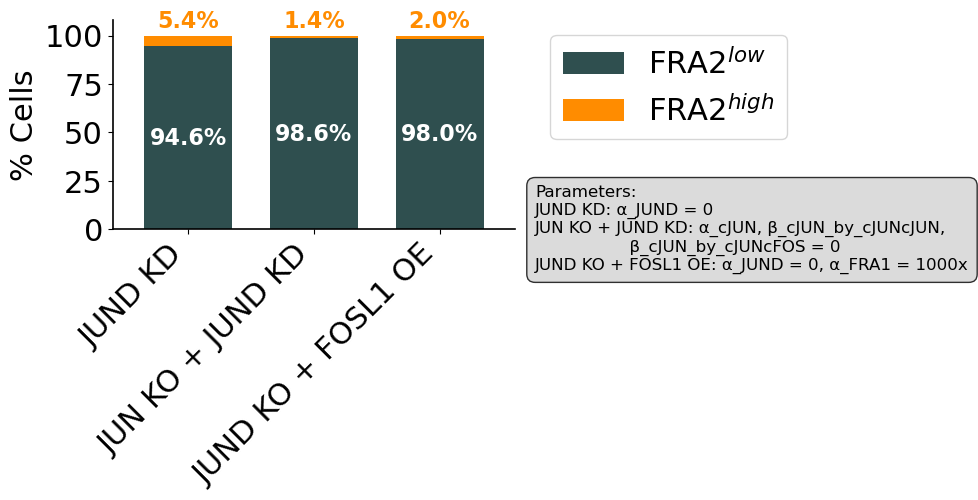

In [11]:
plot_data = combined_df.groupby('pertrub_type')['FRA2_category'].value_counts(normalize=True).mul(100).unstack('FRA2_category')

desired_order = [
    'JUND KD',
    'JUN KO + JUND KD',
    'JUND KO + FOSL1 OE'
]
colors = {
    'FRA2 high': 'darkorange',
    'FRA2 low': 'darkslategray'
}

plot_data = plot_data.reindex(desired_order)

# Create figure with original aspect ratio
fig, ax = plt.subplots(figsize=(8, 5))

# Create the stacked bar plot
bars = plot_data[['FRA2 low', 'FRA2 high']].plot(
    kind='bar',
    stacked=True,
    color=[colors['FRA2 low'], colors['FRA2 high']],
    ax=ax,
    width=0.7
)

# Add percentage labels on bars
for i, container in enumerate(ax.containers):
    if i == 0:  # FRA2 low (bottom segments)
        ax.bar_label(container, 
                    labels=[f'{v:.1f}%' if v > 10 else '' for v in container.datavalues],
                    label_type='center', 
                    color='white', 
                    fontsize=16, 
                    fontweight='bold')
    else:  # FRA2 high (top segments) - place all labels on top of bars
        # Place all FRA2 high labels on top of bars
        for j, v in enumerate(container.datavalues):
            # Get the total bar height (FRA2 low + FRA2 high)
            total_height = 100  # Since it's percentage, total is always 100
            ax.text(j, total_height + 1.5, 
                   f'{v:.1f}%', 
                   ha='center', 
                   va='bottom', 
                   fontsize=16, 
                   fontweight='bold',
                   color='darkorange')

# Customize plot aesthetics
ax.set_ylabel('% Cells')
ax.set_xlabel('')
ax.set_ylim(0, 108)  # Increase upper limit to accommodate labels above bars
ax.set_yticks([0, 25, 50, 75, 100])

# Clean x-axis labels (no parameter information)
ax.set_xticklabels(desired_order, rotation=0, ha='center')

# Create main legend for FRA2 categories
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['FRA2 low'], label='FRA2$^{low}$'),
    Patch(facecolor=colors['FRA2 high'], label='FRA2$^{high}$')
]

ax.legend(handles=legend_elements,
         title='', 
         bbox_to_anchor=(1.05, 1), 
         loc='upper left',
         frameon=True,
         fancybox=True,
         shadow=False)

# Add parameter information as text box on the right side
parameter_text = """Parameters:
JUND KD: α_JUND = 0
JUN KO + JUND KD: α_cJUN, β_cJUN_by_cJUNcJUN,
                  β_cJUN_by_cJUNcFOS = 0
JUND KO + FOSL1 OE: α_JUND = 0, α_FRA1 = 1000x"""

ax.text(1.05, 0, parameter_text, 
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='center',
        horizontalalignment='left',
        bbox=dict(boxstyle='round,pad=0.5', 
                 facecolor='lightgray', 
                 alpha=0.8,
                 edgecolor='black'))

# Clean x-axis labels with rotation (as originally)
ax.set_xticklabels(desired_order, rotation=45, ha='right')

# Add subtle grid
#ax.grid(axis='y', linestyle='--', alpha=0.3, linewidth=0.8)
ax.set_axisbelow(True)

# Improve spacing - adjust for right-side text box
plt.tight_layout()
plt.subplots_adjust(right=0.65)  # Make room for the parameter text on the right
# save the figure
#plt.savefig('6Q_FRA2_distribution_across_peturbations.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Function to sample and format dataframes for combining
def sample_and_format_df(df, initial_col='FRA2 Initial', post_col=None, n_samples=6000):
    """
    Sample rows from a dataframe and format for plotting.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input dataframe containing the data
    initial_col : str
        Name of the column containing initial values
    post_col : str
        Name of the column containing post-perturbation values
    n_samples : int
        Number of random samples to take
    
    Returns:
    --------
    pandas DataFrame
        Sampled and formatted dataframe
    """
    # If post_col is not provided, try to determine based on pertrub_type
    if post_col is None:
        pertrub_type = df['pertrub_type'].iloc[0]
        if pertrub_type == 'FOS KO + JUND KD':
            post_col = 'FRA2 post FOSKO JUNDKD'
        elif pertrub_type == 'JUN KO + JUND KD':
            post_col = 'FRA2 post JUNKO JUNDKD'
        elif pertrub_type == 'JUND KD':
            post_col = 'FRA2 post JUNDKD'
        elif pertrub_type == 'JUND KO + FOSL1 OE':
            post_col = 'FRA2 post JUNDKO FRA1OE'
        else:
            raise ValueError(f"Unknown perturbation type: {pertrub_type}")
    
    # Sample rows
    if len(df) > n_samples:
        sampled_df = df.sample(n_samples, random_state=42)
    else:
        sampled_df = df
    
    # Create formatted dataframe
    formatted_df = pd.DataFrame({
        'FRA2 Initial': sampled_df[initial_col],
        'FRA2': sampled_df[post_col],
        'pertrub_type': sampled_df['pertrub_type']
    })
    
    return formatted_df

# Process each dataframe and combine
def combine_dataframes(dataframes, n_samples=6000):
    """
    Combine multiple dataframes into a single long format dataframe for plotting.
    
    Parameters:
    -----------
    dataframes : list of pandas DataFrames
        List of dataframes to combine
    n_samples : int
        Number of samples to take from each dataframe
        
    Returns:
    --------
    pandas DataFrame
        Combined dataframe in long format
    """
    combined_df = pd.DataFrame()
    
    for df in dataframes:
        formatted_df = sample_and_format_df(df, n_samples=n_samples)
        combined_df = pd.concat([combined_df, formatted_df], ignore_index=True)
    
    return combined_df

# Example usage
# List of dataframes to combine
dfs_to_combine = [junkojundkd, jundkd, jundkd_fosl1oe]

# Combine the dataframes
plot_df = combine_dataframes(dfs_to_combine, n_samples=6800)

# Now plot_df is ready for plotting

In [21]:
# print the unique values of the pertrub_type column
plot_df

,FRA2 Initial,FRA2,pertrub_type
0,1.3,1.0,JUN KO + JUND KD
1,2.5,2.5,JUN KO + JUND KD
2,7.9,8.5,JUN KO + JUND KD
3,2.3,1.7,JUN KO + JUND KD
4,1.3,1.4,JUN KO + JUND KD
...,...,...,...
20395,1.1,1.0,JUND KO + FOSL1 OE
20396,1.4,2.0,JUND KO + FOSL1 OE
20397,1.6,1.9,JUND KO + FOSL1 OE
20398,3.4,4.0,JUND KO + FOSL1 OE


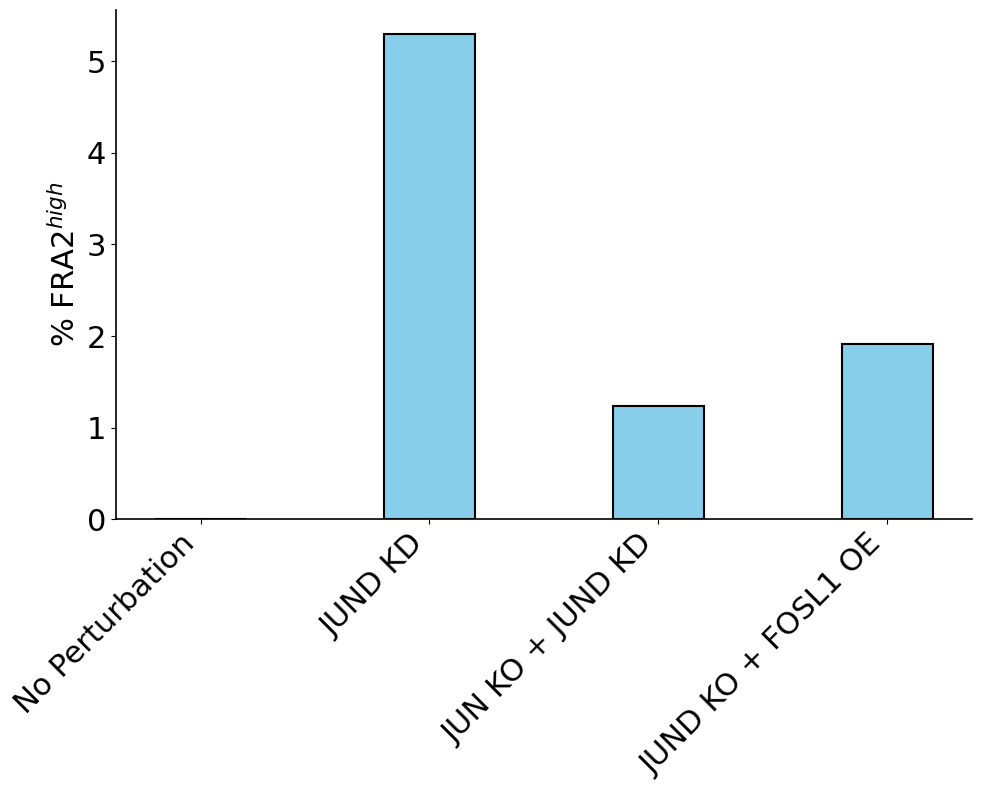

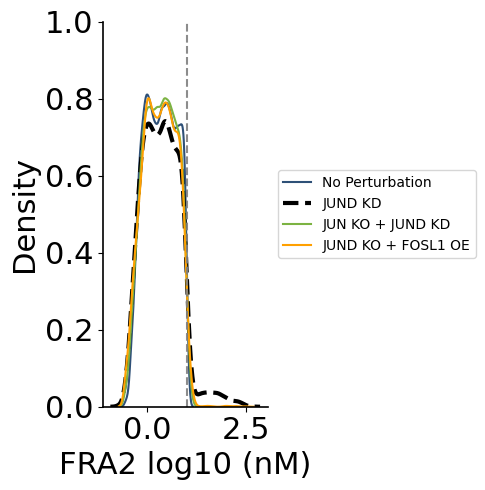

In [29]:
# Calculate high FRA2 percentages and generate plots
def plot_fra2_analysis(plot_df):
    """
    Create two plots:
    1. Bar plot of high FRA2 percentages for each perturbation type (with log scale)
    2. Density plot of log-transformed FRA2 values for each perturbation type
    
    Parameters:
    -----------
    plot_df : pandas DataFrame
        Combined dataframe with FRA2 Initial, FRA2, and pertrub_type columns
    """
    # Create a copy to avoid modifying the original dataframe
    df = plot_df.copy()
    
    # Add log-transformed values
    df['log_FRA2_Initial'] = np.log10(df['FRA2 Initial'])
    df['log_FRA2'] = np.log10(df['FRA2'])
    
    # Add "No Perturbation" entries
    # For each sample, add a corresponding "No Perturbation" entry
    no_perturb_df = df.copy()
    no_perturb_df['pertrub_type'] = 'No Perturbation'
    # Set FRA2 to be FRA2 Initial for "No Perturbation"
    no_perturb_df['FRA2'] = no_perturb_df['FRA2 Initial']
    no_perturb_df['log_FRA2'] = no_perturb_df['log_FRA2_Initial']
    
    # Combine with original data
    combined_df = pd.concat([df, no_perturb_df], ignore_index=True)
    
    # Define the order for plotting
    perturb_order = ['No Perturbation', 'JUND KD', 'JUN KO + JUND KD', 'JUND KO + FOSL1 OE']
    
    # Calculate global threshold based on all FRA2 Initial values
    # This ensures we use the same threshold for all categories
    global_threshold = 1
    
    # Group by perturbation type to calculate percentages
    high_fra2_percentages = []
    
    for perturb in perturb_order:
        if perturb in combined_df['pertrub_type'].unique():
            # Get data for this perturbation type
            subset = combined_df[combined_df['pertrub_type'] == perturb]
            
            # Count samples above threshold and calculate percentage
            high_fra2 = (subset['log_FRA2'] > global_threshold).sum()
            total_samples = len(subset)
            percentage = (high_fra2 / total_samples) * 100
            
            high_fra2_percentages.append({
                'pertrub_type': perturb,
                'percentage': percentage
            })
        else:
            # If some categories not present in the data, add with 0%
            high_fra2_percentages.append({
                'pertrub_type': perturb,
                'percentage': 0.0
            })
    
    # Convert to DataFrame for easier plotting
    result_df = pd.DataFrame(high_fra2_percentages)
    
    # Create bar plot with narrower bars, log scale y-axis, and customized style
    plt.figure(figsize=(10, 8))
    
    # Use plt.bar for more control over bar width
    x_pos = np.arange(len(result_df))
    plt.bar(x_pos, result_df['percentage'], width=0.4, 
            color='skyblue', edgecolor='black', linewidth=1.5)
    
    # Set x-axis labels
    plt.xticks(x_pos, result_df['pertrub_type'], rotation=45, ha='right')
    
    # # Set y-axis to log scale
    # plt.yscale('log')
    
    # # Set y-axis limits from 0 to 10^2
    # plt.ylim(10**-2, 10)
    

    
    # Add threshold value in the title
    #plt.title(f'Percentage of High FRA2 Samples by Perturbation Type (Log Scale)\nThreshold: mean + 2SD = {global_threshold:.3f}')
    plt.xlabel('')
    plt.ylabel('% FRA2$^{high}$')
    plt.tight_layout()
    #save as high res pdf
    plt.savefig('high_fra2_percentage_barplot_COLO858_JUNDKD_model.pdf', dpi=300)
    plt.show()
    
    # # Print the threshold for reference
    # print(f"Global threshold (mean + 2SD of log FRA2 Initial): {global_threshold:.4f}")
    # print(f"Expected percentage above threshold: ~2.28% (theoretical for normal distribution)")
    
    # Figure 2: Density plot of log-transformed FRA2 values
    plt.figure(figsize=(5, 5))
    
    # Define custom color palette
    colors = ['#2E5077', '#000000','#7CB342','#FFA000','#9C27B0','#FFA000', '#795548']
    color_dict = {perturb: color for perturb, color in zip(perturb_order, colors[:len(perturb_order)])}
    
    # Plot density for each perturbation type in the specified order
    for i, perturb in enumerate(perturb_order):
        if perturb in combined_df['pertrub_type'].unique():
            subset = combined_df[combined_df['pertrub_type'] == perturb]
            
            # Check if this is JUND KD to make it dashed and dark
            if perturb == 'JUND KD':
                sns.kdeplot(subset['log_FRA2'], label=perturb, color='#000000', linestyle='--', linewidth=3)
            else:
                sns.kdeplot(subset['log_FRA2'], label=perturb, color=color_dict[perturb])
    
    # Add vertical line for global threshold (without adding to legend)
    plt.axvline(x=global_threshold, linestyle='--', color='gray', alpha=0.9)
    # plt.text(global_threshold, plt.ylim()[1]*0.95, f'Threshold: {global_threshold:.3f}', 
    #             rotation=90, va='top', fontsize=10, color='gray')
    
    #plt.title('Density Distribution of Log-Transformed FRA2 Values')
    plt.xlabel('FRA2 log10 (nM)')
    plt.ylabel('Density')
    # set y lim from 0 to 1.5 
    plt.ylim(0,1)
    # Place legend outside the plot on the right
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), 
               fontsize=10, frameon=True, framealpha=0.8)
    
    #plt.grid(True, alpha=0.2)
    plt.tight_layout()
    # save as high res pdf
    # plt.savefig('high_fra2_percentage_denisty_log10_COLO858_JUNDKD_model.pdf', dpi=300)
    plt.show()
    
    return result_df

# Run the analysis and generate plots
result_df = plot_fra2_analysis(plot_df)